In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split




# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Input, GlobalAveragePooling2D, SeparableConv2D, Multiply,Lambda
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2, VGG16, ResNet50, DenseNet121, MobileNetV2 
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
import warnings
warnings.filterwarnings('ignore')

In [8]:
IMAGE_SIZE = 48
BATCH_SIZE = 32
EPOCHS = 80

TRAIN_PATH = "../input/fer2013/train/"
TEST_PATH = "../input/fer2013/test/"
SELECTED_CLASSES = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [9]:
train_preprocessor = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

test_preprocessor = ImageDataGenerator(rescale=1./255)

# Create training generator
train_generator = train_preprocessor.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    classes=SELECTED_CLASSES,
    shuffle=True
)

# Create validation generator
validation_generator = train_preprocessor.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    classes=SELECTED_CLASSES,
    shuffle=False
)

# Create test generator
test_generator = test_preprocessor.flow_from_directory(
    TEST_PATH,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=SELECTED_CLASSES
)

print("\n✅ Data generators created successfully!")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.

✅ Data generators created successfully!
Training samples: 22619
Validation samples: 5654
Test samples: 7067


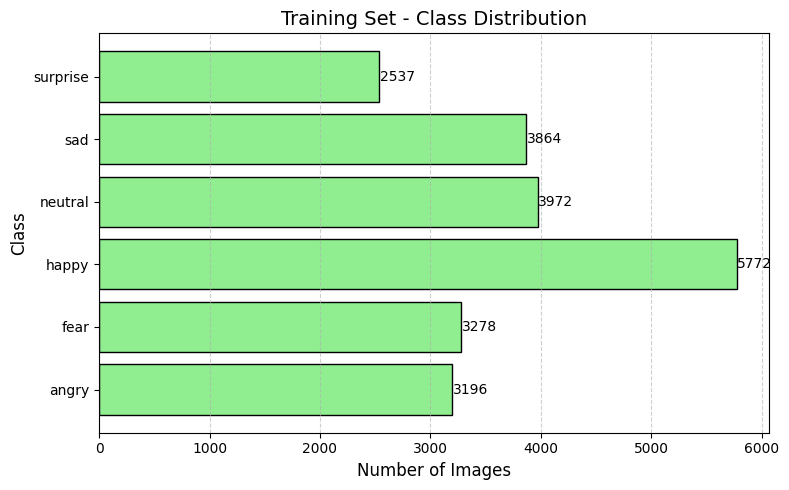

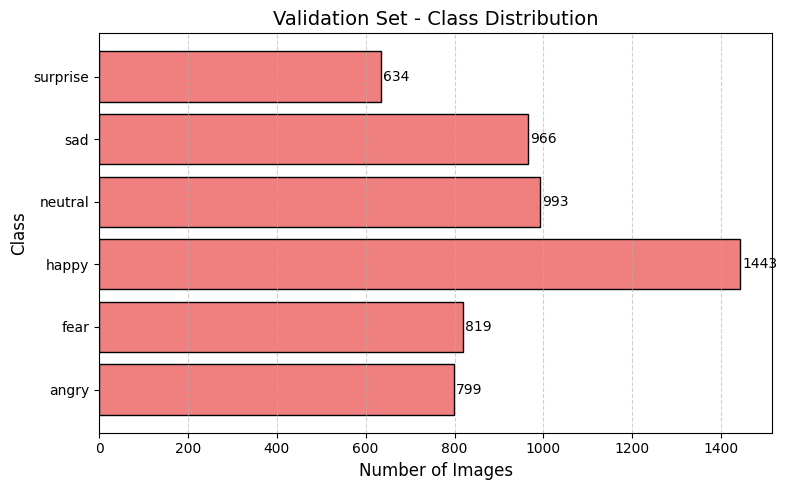

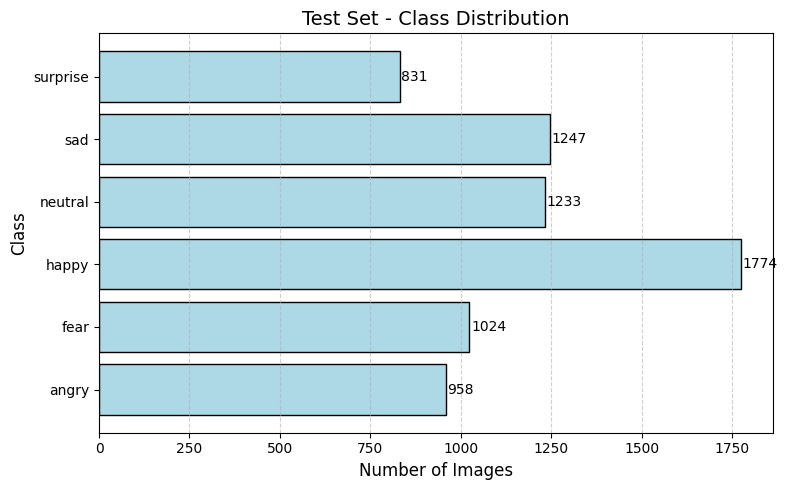

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_class_distribution(data_gen, dataset_name="Dataset", color='skyblue'):
    
    # Extract class indices and labels
    class_indices = data_gen.class_indices
    class_labels = list(class_indices.keys())
    class_counts = pd.Series(data_gen.classes).value_counts().sort_index()

    # Match labels to their counts
    class_counts.index = [class_labels[i] for i in class_counts.index]

    # Plot
    plt.figure(figsize=(8, 5))
    bars = plt.barh(class_counts.index, class_counts.values, color=color, edgecolor='black')
    plt.title(f"{dataset_name} - Class Distribution", fontsize=14)
    plt.xlabel("Number of Images", fontsize=12)
    plt.ylabel("Class", fontsize=12)

    # Annotate bar values
    for bar in bars:
        plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
                 f"{int(bar.get_width())}", va='center', fontsize=10)

    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
visualize_class_distribution(train_generator, "Training Set", color='lightgreen')
visualize_class_distribution(validation_generator, "Validation Set", color='lightcoral')
visualize_class_distribution(test_generator, "Test Set", color='lightblue')

In [11]:
def model_resnet50v2(input_shape, num_classes):
    """Build ResNet50V2 model for grayscale images with fine-tuning."""
    # Create base model
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Create input for grayscale
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Convert grayscale to 3 channels by repeating the channel
    x = tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)

    # Pass through ResNet50
    x = base_model(x, training=False)

    # Add custom head
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Fine-tuning: Unfreeze last 30 layers
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    return model

In [12]:
# ------------------ ResNet50V2 ------------------
print("Building ResNet50V2 Model...")
resnetv2_model = model_resnet50v2((IMAGE_SIZE, IMAGE_SIZE, 1), len(SELECTED_CLASSES))
resnetv2_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


Building ResNet50V2 Model...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
# Store training histories and results for comparison at the end
histories = {}
results = {}


TRAINING RESNET50V2 MODEL
Epoch 1/80
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2281 - loss: 2.0265
Epoch 1: val_accuracy improved from -inf to 0.31500, saving model to best_resnet50v2_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 79s 79ms/step - accuracy: 0.2281 - loss: 2.0262 - val_accuracy: 0.3150 - val_loss: 1.6885 - learning_rate: 1.0000e-04
Epoch 2/80
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2891 - loss: 1.7843
Epoch 2: val_accuracy improved from 0.31500 to 0.34843, saving model to best_resnet50v2_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.2891 - loss: 1.7843 - val_accuracy: 0.3484 - val_loss: 1.6249 - learning_rate: 1.0000e-04
Epoch 3/80
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3247 - loss: 1.6865
Epoch 3: val_accuracy improved from 0.34843 to 0.36293, saving model to best_resnet50v2_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.3247 - loss: 1.6865 - val_accuracy: 0.3629 - val_loss: 1.5822 - 

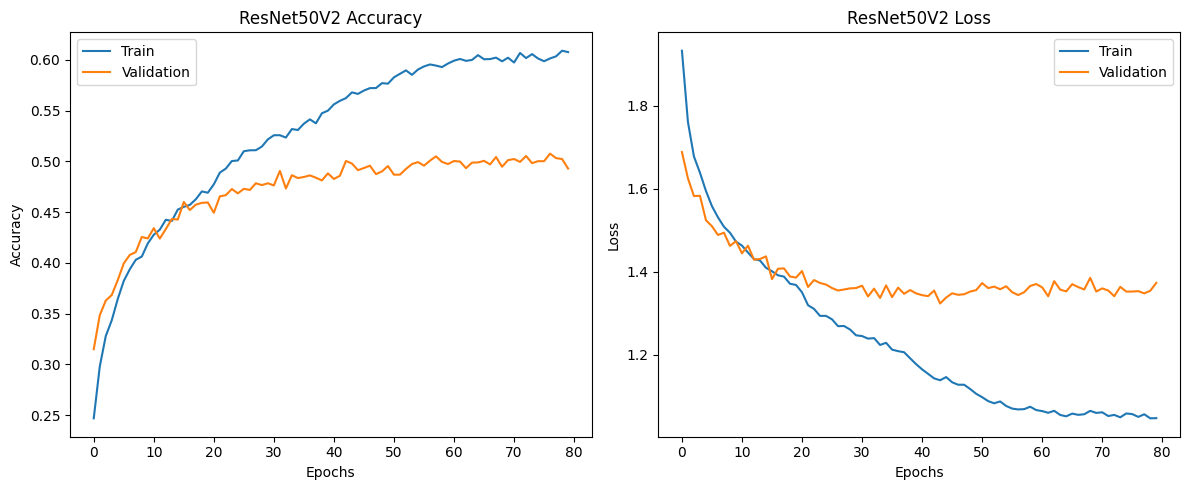

221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step


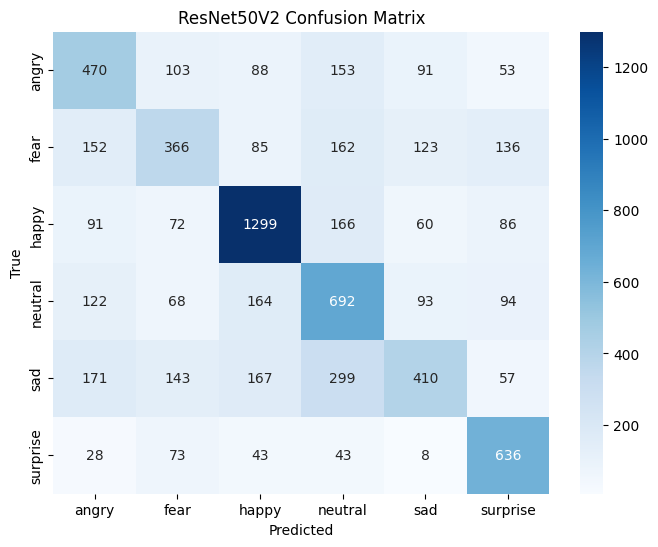


Classification Report (ResNet50V2):

              precision    recall  f1-score   support

       angry       0.45      0.49      0.47       958
        fear       0.44      0.36      0.40      1024
       happy       0.70      0.73      0.72      1774
     neutral       0.46      0.56      0.50      1233
         sad       0.52      0.33      0.40      1247
    surprise       0.60      0.77      0.67       831

    accuracy                           0.55      7067
   macro avg       0.53      0.54      0.53      7067
weighted avg       0.54      0.55      0.54      7067

✅ ResNet50V2 model saved!



In [14]:
# ==============================================
# 1️⃣ Train and Evaluate ResNet50V2 Model
# ==============================================

print("\n" + "="*60)
print("TRAINING RESNET50V2 MODEL")
print("="*60)

checkpoint = ModelCheckpoint(
    "best_resnet50v2_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
callbacks = [checkpoint, early_stop, reduce_lr]

history_resnet = resnetv2_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
histories['resnet50v2'] = history_resnet

# Evaluate ResNet50V2
test_loss, test_acc = resnetv2_model.evaluate(test_generator, verbose=0)
results['resnet50v2'] = {'accuracy': test_acc, 'loss': test_loss}
print(f"\nResNet50V2 - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Accuracy & Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train')
plt.plot(history_resnet.history['val_accuracy'], label='Validation')
plt.title("ResNet50V2 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train')
plt.plot(history_resnet.history['val_loss'], label='Validation')
plt.title("ResNet50V2 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix and Report
pred_resnet = resnetv2_model.predict(test_generator)
y_pred_resnet = np.argmax(pred_resnet, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("ResNet50V2 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report (ResNet50V2):\n")
print(classification_report(y_true, y_pred_resnet, target_names=class_labels))

# Save model
resnetv2_model.save("fer_resnet50v2_grayscale_model.h5")
print("✅ ResNet50V2 model saved!\n")

In [15]:
def model_vgg16(input_shape, num_classes):
    """Build a VGG16 model for grayscale images with fine-tuning."""
    
    
    # Create base model
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Create input for grayscale
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Convert grayscale to 3 channels
    x = tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)

    # Pass through VGG16
    x = base_model(x, training=False)

    # Add custom head
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Fine-tuning: Unfreeze last 4 blocks
    base_model.trainable = True
    for layer in base_model.layers[:15]:
        layer.trainable = False

    return model

In [16]:
# ------------------ VGG16 ------------------
print("Building VGG16 Model...")
vgg16_model = model_vgg16((IMAGE_SIZE, IMAGE_SIZE, 1), len(SELECTED_CLASSES))
vgg16_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Building VGG16 Model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



TRAINING VGG16 MODEL
Epoch 1/80
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2390 - loss: 2.2642
Epoch 1: val_accuracy improved from -inf to 0.29377, saving model to best_vgg16_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - accuracy: 0.2391 - loss: 2.2638 - val_accuracy: 0.2938 - val_loss: 2.0482 - learning_rate: 1.0000e-04
Epoch 2/80
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3061 - loss: 1.8974
Epoch 2: val_accuracy improved from 0.29377 to 0.34507, saving model to best_vgg16_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.3061 - loss: 1.8973 - val_accuracy: 0.3451 - val_loss: 1.6657 - learning_rate: 1.0000e-04
Epoch 3/80
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3413 - loss: 1.7623
Epoch 3: val_accuracy improved from 0.34507 to 0.38345, saving model to best_vgg16_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.3413 - loss: 1.7623 - val_accuracy: 0.3834 - val_loss: 1.5939 - learning_rate: 1.000

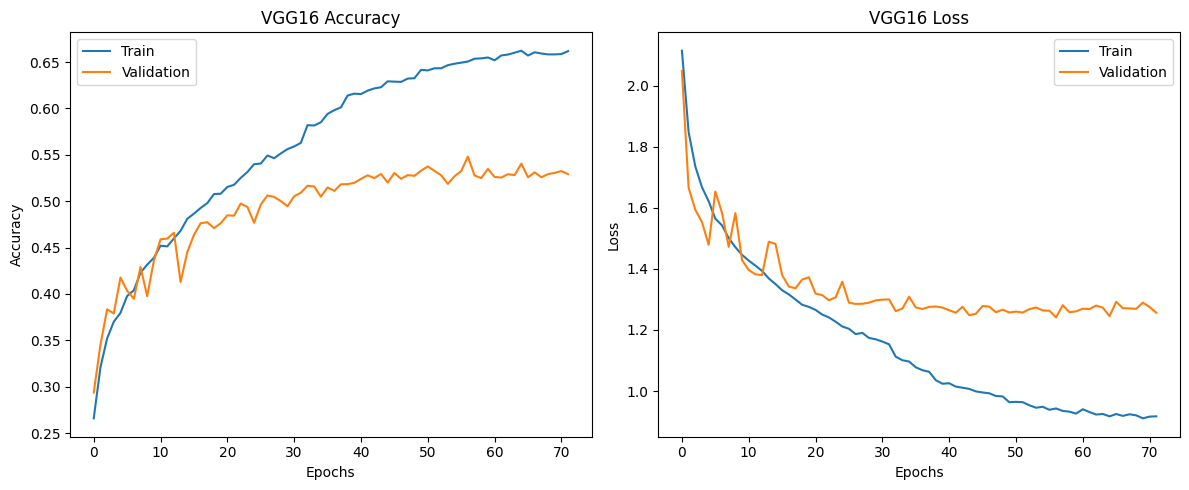

221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step


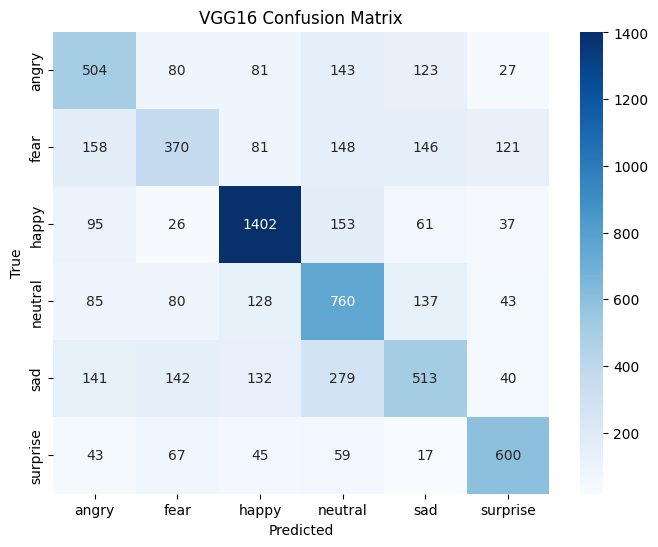


Classification Report (VGG16):

              precision    recall  f1-score   support

       angry       0.49      0.53      0.51       958
        fear       0.48      0.36      0.41      1024
       happy       0.75      0.79      0.77      1774
     neutral       0.49      0.62      0.55      1233
         sad       0.51      0.41      0.46      1247
    surprise       0.69      0.72      0.71       831

    accuracy                           0.59      7067
   macro avg       0.57      0.57      0.57      7067
weighted avg       0.58      0.59      0.58      7067

✅ VGG16 model saved!



In [17]:
# ==============================================
# 2️⃣ Train and Evaluate VGG16 Model
# ==============================================

print("\n" + "="*60)
print("TRAINING VGG16 MODEL")
print("="*60)

checkpoint = ModelCheckpoint(
    "best_vgg16_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode='max',
    verbose=1
)
callbacks = [checkpoint, early_stop, reduce_lr]

history_vgg = vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
histories['vgg16'] = history_vgg

# Evaluate VGG16
test_loss, test_acc = vgg16_model.evaluate(test_generator, verbose=0)
results['vgg16'] = {'accuracy': test_acc, 'loss': test_loss}
print(f"\nVGG16 - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Accuracy & Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['accuracy'], label='Train')
plt.plot(history_vgg.history['val_accuracy'], label='Validation')
plt.title("VGG16 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['loss'], label='Train')
plt.plot(history_vgg.history['val_loss'], label='Validation')
plt.title("VGG16 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix and Report
pred_vgg = vgg16_model.predict(test_generator)
y_pred_vgg = np.argmax(pred_vgg, axis=1)

cm = confusion_matrix(y_true, y_pred_vgg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report (VGG16):\n")
print(classification_report(y_true, y_pred_vgg, target_names=class_labels))

vgg16_model.save("fer_vgg16_grayscale_model.h5")
print("✅ VGG16 model saved!\n")

In [18]:
def model_densenet121(input_shape, num_classes):
    """Build DenseNet121 model for grayscale images with fine-tuning."""
    # Create base model
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Create input for grayscale
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Convert grayscale to 3 channels
    x = tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)

    # Pass through DenseNet121
    x = base_model(x, training=False)

    # Add custom head
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Fine-tuning: Unfreeze last 100 layers
    base_model.trainable = True
    for layer in base_model.layers[:-100]:
        layer.trainable = False

    return model

In [19]:
# ------------------ DenseNet121 ------------------
print("Building DenseNet121 Model...")
densenet_model = model_densenet121((IMAGE_SIZE, IMAGE_SIZE, 1), len(SELECTED_CLASSES))
densenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Building DenseNet121 Model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



TRAINING DENSENET121 MODEL
Epoch 1/80
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2199 - loss: 2.4031
Epoch 1: val_accuracy improved from -inf to 0.32897, saving model to best_densenet121_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 142s 120ms/step - accuracy: 0.2199 - loss: 2.4027 - val_accuracy: 0.3290 - val_loss: 1.7321 - learning_rate: 1.0000e-04
Epoch 2/80
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2934 - loss: 1.9846
Epoch 2: val_accuracy improved from 0.32897 to 0.35656, saving model to best_densenet121_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 54s 76ms/step - accuracy: 0.2934 - loss: 1.9846 - val_accuracy: 0.3566 - val_loss: 1.6428 - learning_rate: 1.0000e-04
Epoch 3/80
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.3133 - loss: 1.8688
Epoch 3: val_accuracy improved from 0.35656 to 0.35921, saving model to best_densenet121_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 110s 155ms/step - accuracy: 0.3133 - loss: 1.8688 - val_accuracy: 0.3592 - val_loss: 

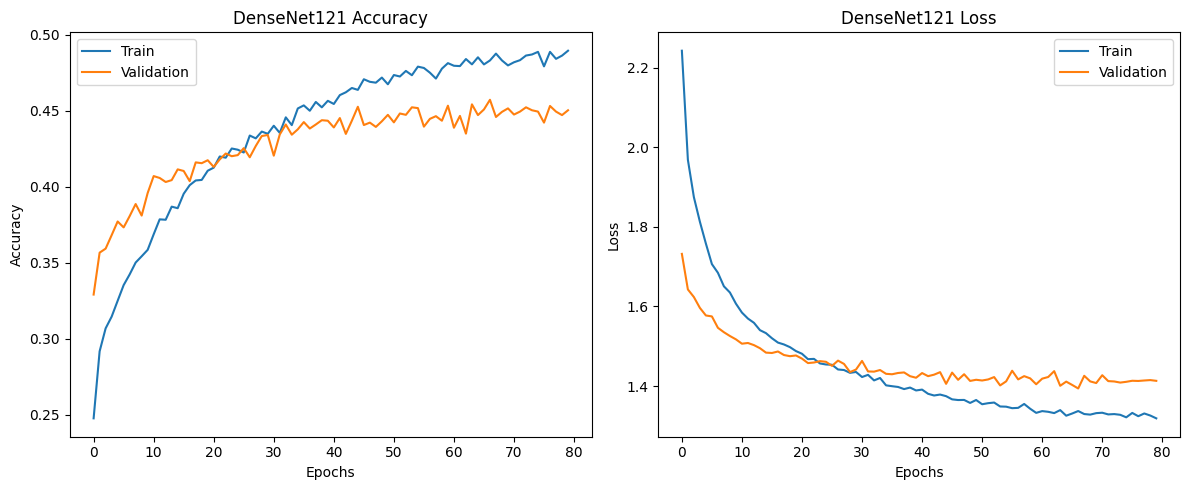

221/221 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step


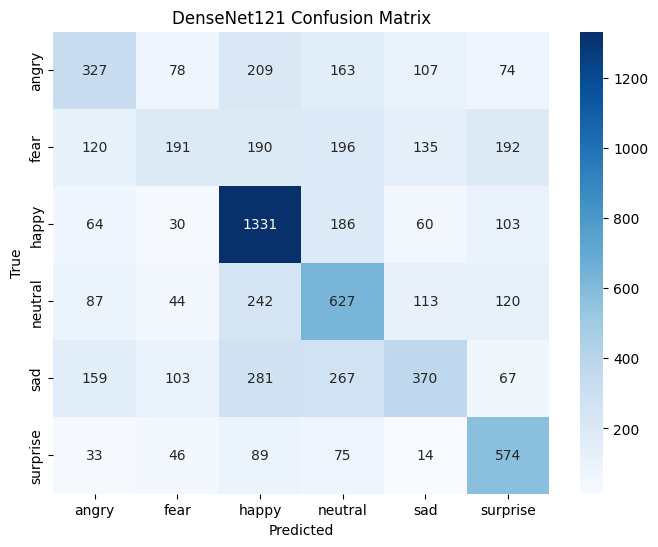


Classification Report (DenseNet121):

              precision    recall  f1-score   support

       angry       0.41      0.34      0.37       958
        fear       0.39      0.19      0.25      1024
       happy       0.57      0.75      0.65      1774
     neutral       0.41      0.51      0.46      1233
         sad       0.46      0.30      0.36      1247
    surprise       0.51      0.69      0.59       831

    accuracy                           0.48      7067
   macro avg       0.46      0.46      0.45      7067
weighted avg       0.47      0.48      0.46      7067

✅ DenseNet121 model saved!



In [20]:
# ==============================================
# 3️⃣ Train and Evaluate DenseNet121 Model
# ==============================================

print("\n" + "="*60)
print("TRAINING DENSENET121 MODEL")
print("="*60)

checkpoint = ModelCheckpoint(
    "best_densenet121_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode='max',
    verbose=1
)
callbacks = [checkpoint, early_stop, reduce_lr]

history_dense = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
histories['densenet121'] = history_dense

# Evaluate DenseNet121
test_loss, test_acc = densenet_model.evaluate(test_generator, verbose=0)
results['densenet121'] = {'accuracy': test_acc, 'loss': test_loss}
print(f"\nDenseNet121 - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Accuracy & Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dense.history['accuracy'], label='Train')
plt.plot(history_dense.history['val_accuracy'], label='Validation')
plt.title("DenseNet121 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dense.history['loss'], label='Train')
plt.plot(history_dense.history['val_loss'], label='Validation')
plt.title("DenseNet121 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix and Report
pred_dense = densenet_model.predict(test_generator)
y_pred_dense = np.argmax(pred_dense, axis=1)

cm = confusion_matrix(y_true, y_pred_dense)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("DenseNet121 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report (DenseNet121):\n")
print(classification_report(y_true, y_pred_dense, target_names=class_labels))

densenet_model.save("fer_densenet121_grayscale_model.h5")
print("✅ DenseNet121 model saved!\n")

In [21]:
def build_efficientnetb0_grayscale(input_shape, num_classes):
    """Build EfficientNetB0 model for grayscale images with fine-tuning."""
    # Create base model
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Create input for grayscale
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Convert grayscale to 3 channels
    x = tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)

    # Pass through EfficientNetB0
    x = base_model(x, training=False)

    # Add custom head
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Fine-tuning: Unfreeze last 50 layers
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    return model


In [22]:
# ------------------ EfficientNetB0 ------------------
print("Building EfficientNetB0 Model...")
efficientnet_model = build_efficientnetb0_grayscale((IMAGE_SIZE, IMAGE_SIZE, 1), len(SELECTED_CLASSES))
efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"])

Building EfficientNetB0 Model...



TRAINING EFFICIENTNETB0 MODEL
Epoch 1/80
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1926 - loss: 2.7682
Epoch 1: val_accuracy improved from -inf to 0.21701, saving model to best_efficientnetb0_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 173s 122ms/step - accuracy: 0.1926 - loss: 2.7680 - val_accuracy: 0.2170 - val_loss: 2.1786 - learning_rate: 1.0000e-04
Epoch 2/80
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2416 - loss: 2.3254
Epoch 2: val_accuracy did not improve from 0.21701
707/707 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.2417 - loss: 2.3252 - val_accuracy: 0.2131 - val_loss: 1.8217 - learning_rate: 1.0000e-04
Epoch 3/80
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2619 - loss: 2.0710
Epoch 3: val_accuracy did not improve from 0.21701
707/707 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.2619 - loss: 2.0709 - val_accuracy: 0.1946 - val_loss: 1.8123 - learning_rate: 1.0000e-04
Epoch 4/80
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accurac

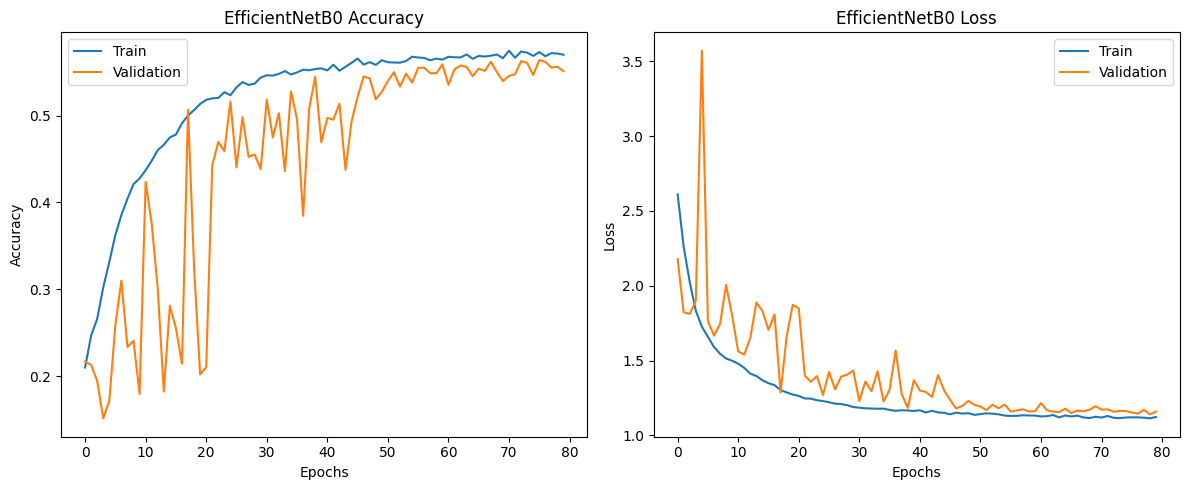

221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step


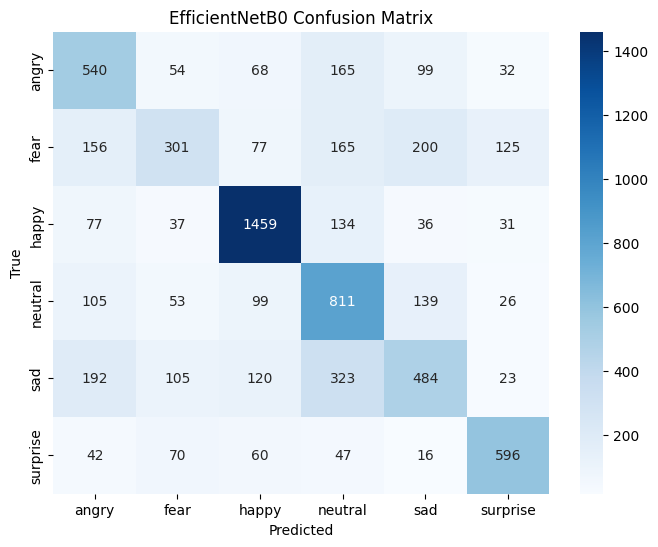


Classification Report (EfficientNetB0):

              precision    recall  f1-score   support

       angry       0.49      0.56      0.52       958
        fear       0.49      0.29      0.37      1024
       happy       0.77      0.82      0.80      1774
     neutral       0.49      0.66      0.56      1233
         sad       0.50      0.39      0.44      1247
    surprise       0.72      0.72      0.72       831

    accuracy                           0.59      7067
   macro avg       0.58      0.57      0.57      7067
weighted avg       0.59      0.59      0.58      7067

✅ EfficientNetB0 model saved!



In [23]:
# ==============================================
# 4️⃣ TRAIN AND EVALUATE EFFICIENTNETB0 MODEL
# ==============================================

print("\n" + "="*60)
print("TRAINING EFFICIENTNETB0 MODEL")
print("="*60)

# Create EfficientNetB0 model for grayscale
def create_efficientnetb0(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

efficientnet_model = create_efficientnetb0((IMAGE_SIZE, IMAGE_SIZE, 1), len(SELECTED_CLASSES))
efficientnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint = ModelCheckpoint("best_efficientnetb0_model.keras", monitor="val_accuracy", save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
callbacks = [checkpoint, early_stop, reduce_lr]

history_efficient = efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
histories['efficientnetb0'] = history_efficient

test_loss, test_acc = efficientnet_model.evaluate(test_generator, verbose=0)
results['efficientnetb0'] = {'accuracy': test_acc, 'loss': test_loss}
print(f"\nEfficientNetB0 - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_efficient.history['accuracy'], label='Train')
plt.plot(history_efficient.history['val_accuracy'], label='Validation')
plt.title("EfficientNetB0 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_efficient.history['loss'], label='Train')
plt.plot(history_efficient.history['val_loss'], label='Validation')
plt.title("EfficientNetB0 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

pred_efficient = efficientnet_model.predict(test_generator)
y_pred_efficient = np.argmax(pred_efficient, axis=1)
cm = confusion_matrix(y_true, y_pred_efficient)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("EfficientNetB0 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report (EfficientNetB0):\n")
print(classification_report(y_true, y_pred_efficient, target_names=class_labels))
efficientnet_model.save("fer_efficientnetb0_grayscale_model.h5")
print("✅ EfficientNetB0 model saved!\n")


In [24]:
def build_mobilenetv2_grayscale(input_shape, num_classes):
    """Build MobileNetV2 model for grayscale images with fine-tuning."""
    # Base model
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Input for grayscale
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Convert grayscale -> RGB
    x = tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)

    # Pass through base model
    x = base_model(x, training=False)

    # Custom head
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Fine-tune last 40 layers
    base_model.trainable = True
    for layer in base_model.layers[:-40]:
        layer.trainable = False

    return model

In [25]:
# ------------------ MobileNetV2 ------------------
print("Building MobileNetV2 Model...")
mobilenet_model = build_mobilenetv2_grayscale((IMAGE_SIZE, IMAGE_SIZE, 1), len(SELECTED_CLASSES))
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


Building MobileNetV2 Model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



TRAINING MOBILENETV2 MODEL
Epoch 1/80


E0000 00:00:1760290812.012773     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760290812.226707     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760290812.444975     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760290812.631278     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760290812.819011     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


279/707 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.1873 - loss: 2.1716

E0000 00:00:1760290832.618075     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760290832.832538     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760290833.051550     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760290833.240466     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2134 - loss: 2.0580
Epoch 1: val_accuracy improved from -inf to 0.28422, saving model to best_mobilenetv2_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 77s 74ms/step - accuracy: 0.2135 - loss: 2.0577 - val_accuracy: 0.2842 - val_loss: 1.7161 - learning_rate: 1.0000e-04
Epoch 2/80
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2736 - loss: 1.7883
Epoch 2: val_accuracy improved from 0.28422 to 0.32366, saving model to best_mobilenetv2_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.2737 - loss: 1.7883 - val_accuracy: 0.3237 - val_loss: 1.7471 - learning_rate: 1.0000e-04
Epoch 3/80
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2980 - loss: 1.7139
Epoch 3: val_accuracy improved from 0.32366 to 0.34453, saving model to best_mobilenetv2_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.2980 - loss: 1.7139 - val_accuracy: 0.3445 - val_loss: 1.6885 - learning_rate: 1.0000e-04
Epoch 4/8

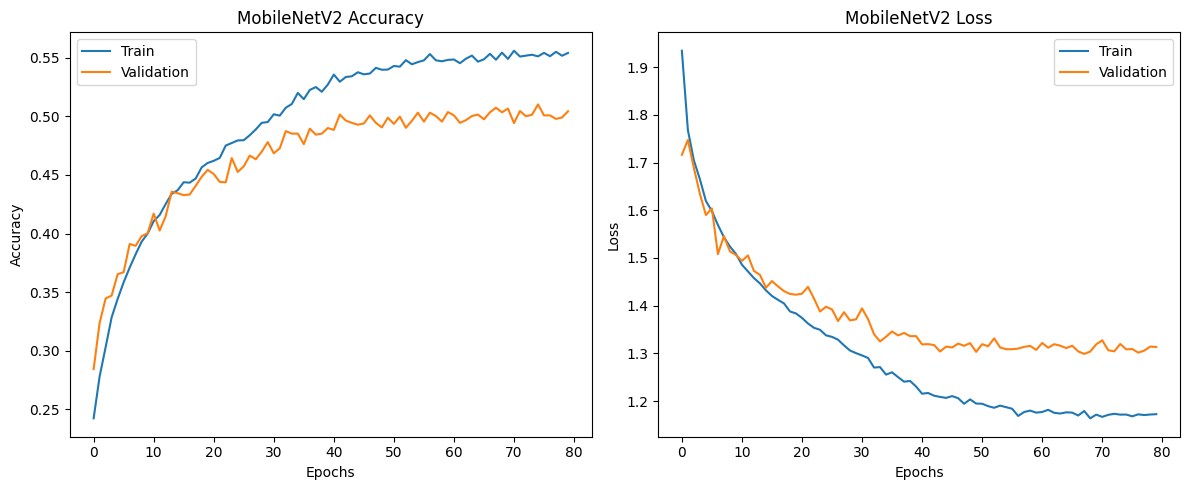

221/221 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step


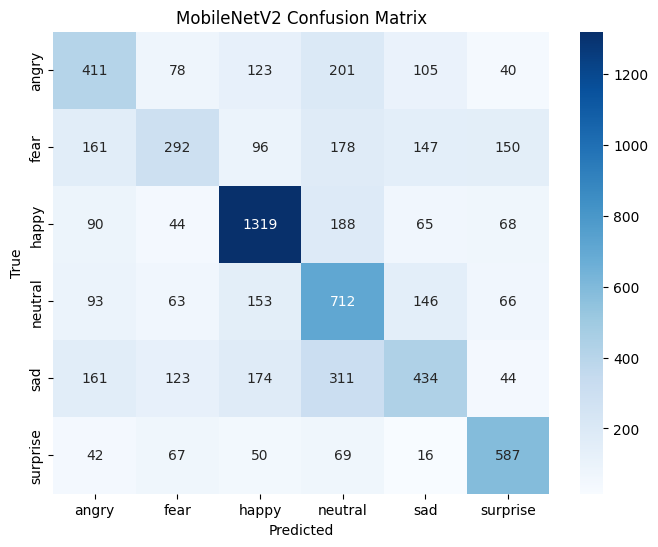


Classification Report (MobileNetV2):

              precision    recall  f1-score   support

       angry       0.43      0.43      0.43       958
        fear       0.44      0.29      0.35      1024
       happy       0.69      0.74      0.72      1774
     neutral       0.43      0.58      0.49      1233
         sad       0.48      0.35      0.40      1247
    surprise       0.61      0.71      0.66       831

    accuracy                           0.53      7067
   macro avg       0.51      0.51      0.51      7067
weighted avg       0.53      0.53      0.52      7067

✅ MobileNetV2 model saved!



In [26]:
# ==============================================
# 5️⃣ TRAIN AND EVALUATE MOBILENETV2 MODEL
# ==============================================

print("\n" + "="*60)
print("TRAINING MOBILENETV2 MODEL")
print("="*60)

checkpoint = ModelCheckpoint(
    "best_mobilenetv2_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode='max',
    verbose=1
)
callbacks = [checkpoint, early_stop, reduce_lr]

# ------------------ Train Model ------------------
history_mobile = mobilenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Store training history and results
histories['mobilenetv2'] = history_mobile

# ------------------ Evaluate Model ------------------
test_loss, test_acc = mobilenet_model.evaluate(test_generator, verbose=0)
results['mobilenetv2'] = {'accuracy': test_acc, 'loss': test_loss}
print(f"\nMobileNetV2 - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# ------------------ Accuracy & Loss Curves ------------------
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mobile.history['accuracy'], label='Train')
plt.plot(history_mobile.history['val_accuracy'], label='Validation')
plt.title("MobileNetV2 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_mobile.history['loss'], label='Train')
plt.plot(history_mobile.history['val_loss'], label='Validation')
plt.title("MobileNetV2 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# ------------------ Confusion Matrix ------------------
pred_mobile = mobilenet_model.predict(test_generator)
y_pred_mobile = np.argmax(pred_mobile, axis=1)
cm = confusion_matrix(y_true, y_pred_mobile)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("MobileNetV2 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ------------------ Classification Report ------------------
print("\nClassification Report (MobileNetV2):\n")
print(classification_report(y_true, y_pred_mobile, target_names=class_labels))

# ------------------ Save Model ------------------
mobilenet_model.save("fer_mobilenetv2_grayscale_model.h5")
print("✅ MobileNetV2 model saved!\n")

In [27]:
# ==============================================
# Final Model Comparison Summary
# ==============================================

print("\n" + "="*70)
print("FINAL MODEL PERFORMANCE COMPARISON")
print("="*70)
for name, result in results.items():
    print(f"{name.upper():<20} - Test Accuracy: {result['accuracy']:.4f}, Test Loss: {result['loss']:.4f}")

best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
print(f"\n🎯 BEST MODEL: {best_model_name.upper()} with accuracy {results[best_model_name]['accuracy']:.4f}")
print("\n✅ All models trained, evaluated, and compared successfully!")


FINAL MODEL PERFORMANCE COMPARISON
RESNET50V2           - Test Accuracy: 0.5480, Test Loss: 1.2777
VGG16                - Test Accuracy: 0.5871, Test Loss: 1.1642
DENSENET121          - Test Accuracy: 0.4839, Test Loss: 1.3374
EFFICIENTNETB0       - Test Accuracy: 0.5930, Test Loss: 1.0680
MOBILENETV2          - Test Accuracy: 0.5313, Test Loss: 1.2255

🎯 BEST MODEL: EFFICIENTNETB0 with accuracy 0.5930

✅ All models trained, evaluated, and compared successfully!
